In [28]:
import pandas_patches
pandas_patches.patch()

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%pylab inline
import pandas as pd
import pathlib
import importlib
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
import xgboost as xgb
from sklearn import pipeline
import sklearn.model_selection as sms
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from stone_type_concentration_regressor import MyColTransformer
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

In [5]:
path_wvls_dict = '/2tb_drive/mnoc_urology/stones/eem/eem_kno/pickles/wvls_dict'
wvls_dict = stc.load_data(path_wvls_dict)

In [6]:
path = './pickles/merged_data'
df = stc.load_data(path)

In [30]:
df_train_test = df

In [32]:
X = df_train_test[df_train_test.columns[4:]]
y = df_train_test[df_train_test.columns[1:4]]

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

In [34]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [62]:
import catboost
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_absolute_error as mae
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor


def objective(trial):
    # boundaries for the optimizer's
    
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    ct_pca_n_components = trial.suggest_int("ct_pca_n_components", 5, 50, step=5)
#     border_count = trial.suggest_int('border_count', 32, 255)
#     pca_n_components = trial.suggest_int("pca_n_components", 2, 12, step=2)

    # create new model(and all parameters) every iteration
    base_model = RandomForestRegressor(
#         objective='MultiRMSE',
#         learning_rate=0.05,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,

    )
    regressor = RegressorChain(base_model)
    scaler = StandardScaler()
    norm = Normalizer()
    ct_pca = MyColTransformer(wvls_dict,n_components=ct_pca_n_components, use_drs=False)
#     pca = PCA(n_components=pca_n_components)

    model = pipeline.Pipeline(

        steps = [

                ('scaler', scaler),
                ('ct_pca', ct_pca),   
#                 
#                 ('pca', pca),
                ('regressor', regressor)
        ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
#     boot_score_test = bootstrap_metric(
#         y_test,
#         y_pred,
#         metric_fn=lambda x, y: mse(y_true=x, y_pred=y),
#     )
    
    trial.set_user_attr("train_metric", mae(y_train, model.predict(X_train)))

    return mae(y_test, y_pred) #boot_score.mean()


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=optuna.samplers.TPESampler()
)

study.optimize(
    objective, n_trials=100
)  # The more iterations, the higher the chances of catching the most optimal hyperparameters

[I 2024-06-07 14:13:54,426] A new study created in memory with name: Optimizer
[I 2024-06-07 14:13:56,875] Trial 0 finished with value: 0.23603271667105727 and parameters: {'n_estimators': 52, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3, 'ct_pca_n_components': 50}. Best is trial 0 with value: 0.23603271667105727.
[I 2024-06-07 14:13:58,423] Trial 1 finished with value: 0.2340862154712086 and parameters: {'n_estimators': 106, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'ct_pca_n_components': 25}. Best is trial 1 with value: 0.2340862154712086.
[I 2024-06-07 14:14:00,988] Trial 2 finished with value: 0.23671821784406624 and parameters: {'n_estimators': 53, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'ct_pca_n_components': 45}. Best is trial 1 with value: 0.2340862154712086.
[I 2024-06-07 14:14:02,667] Trial 3 finished with value: 0.2441332326637354 and parameters: {'n_estimators': 152, 'max_depth': 5, 'min_samples_split': 2, 'min_

In [63]:
all_trials = study.trials_dataframe()

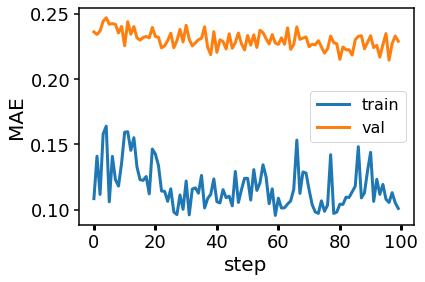

In [64]:
all_trials = study.trials_dataframe()
plot(all_trials['user_attrs_train_metric'], label='train')
plot(all_trials['value'], label='val')

plt.ylabel('MAE')
plt.xlabel('step')
plt.legend()

In [65]:
params = ["n_estimators", "max_depth", "min_samples_split", 'min_samples_leaf', 'ct_pca_n_components' ]
optuna.visualization.plot_slice(study, params=params, target_name="mean_absolute_error")

In [66]:
study.best_params

{'n_estimators': 101,
 'max_depth': 5,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'ct_pca_n_components': 25}

In [67]:
m = all_trials.value == all_trials.value.min()
all_trials[m]

,number,value,datetime_start,datetime_complete,duration,params_ct_pca_n_components,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,user_attrs_train_metric,state
96,96,0.214427,2024-06-07 14:17:08.443165,2024-06-07 14:17:10.586872,0 days 00:00:02.143707,25,5,3,6,101,0.105525,COMPLETE


In [68]:
optuna.visualization.plot_param_importances(study)

In [70]:
 base_model = RandomForestRegressor(
#         objective='MultiRMSE',
#         learning_rate=0.05,
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_samples_split=study.best_params['min_samples_split'],
        min_samples_leaf=study.best_params['min_samples_leaf'],

)

regressor = RegressorChain(base_model)
scaler = StandardScaler()
norm = Normalizer()
ct_pca = MyColTransformer(wvls_dict,n_components=study.best_params['ct_pca_n_components'], use_drs=True)
#     pca = PCA(n_components=pca_n_components)

model_tuned = pipeline.Pipeline(

    steps = [
#         ('norm', norm),
                ('scaler', scaler),
            ('ct_pca', ct_pca),   
#                 
#                 ('pca', pca),
            ('regressor', regressor)
    ])
model_tuned.fit(X_train, y_train)  # train the model
y_pred = model_tuned.predict(X_test)  # get predictions
print('test mae', mae(y_test, y_pred))

test mae 0.21158138410252658


In [71]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse


def mse_for_each_class(y_test, y_pred):
    classes = ['oxalate', 'urate', 'hydroxy', 'unknown']
    l, cl = y_test.shape
    for i in range(cl):
        y_test_ = y_test[:, i]
        y_pred_ = y_pred[:, i]
        mae_ = mae(y_test_, y_pred_)
        rmse_ = rmse(y_test_, y_pred_, squared=False)
        print(classes[i], 'mae:', round(mae_, 2), 'rmse:', round(rmse_, 2))
    

In [72]:
mse_for_each_class(y_test, y_pred)

oxalate mae: 0.24 rmse: 0.29
urate mae: 0.13 rmse: 0.22
hydroxy mae: 0.26 rmse: 0.33


In [73]:
y_pred_train = model_tuned.predict(X_train)  # get predictions
print('train mae', mae(y_train, y_pred_train))

train mae 0.09790303020887824


In [74]:
mse_for_each_class(y_train, y_pred_train)

oxalate mae: 0.11 rmse: 0.14
urate mae: 0.08 rmse: 0.15
hydroxy mae: 0.1 rmse: 0.16


In [44]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class ConstantRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.constant_value = None

    def fit(self, X, y):
        # Вычисляем среднее значение y в обучающем наборе
        self.constant_value = np.mean(y, axis=0)
        return self

    def predict(self, X):
        # Возвращаем константное значение для всех наблюдений
        return np.array([self.constant_value]*X.shape[0])


In [45]:
constant_reg = ConstantRegressor()
constant_reg.fit(X_train, y_train)

ConstantRegressor()

In [27]:
pred_constant = constant_reg.predict(X_test)

In [28]:
mse_for_each_class(y_test, pred_constant)

oxalate mae: 0.37 rmse: 0.4
urate mae: 0.25 rmse: 0.28
hydroxy mae: 0.32 rmse: 0.4


In [43]:
ct_pca_n_components =  study.best_params['ct_pca_n_components']
# pca_n_components =  6

scaler = StandardScaler()
norm = Normalizer()
ct_pca = MyColTransformer(wvls_dict,n_components=ct_pca_n_components, use_drs=True)
# pca = PCA(n_components=pca_n_components)
model = pipeline.Pipeline(

        steps = [
                ('norm', norm),
#                 ('scaler', scaler),
                ('ct_pca', ct_pca),   

#                 ('pca', pca),
#             ('scaler', scaler),
#                 ('regressor', regressor)
        ])

In [44]:
features_train = model.fit_transform(X_train, y_train)
features_test = model.transform(X_test)

/tmp/ipykernel_98575/3606404009.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



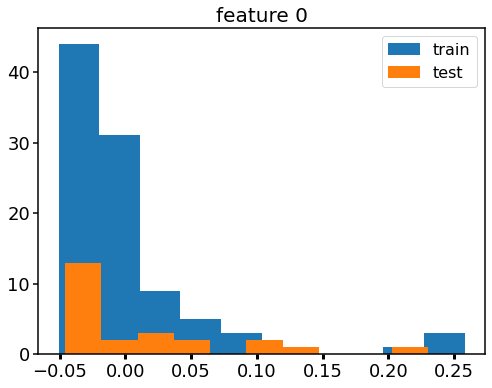

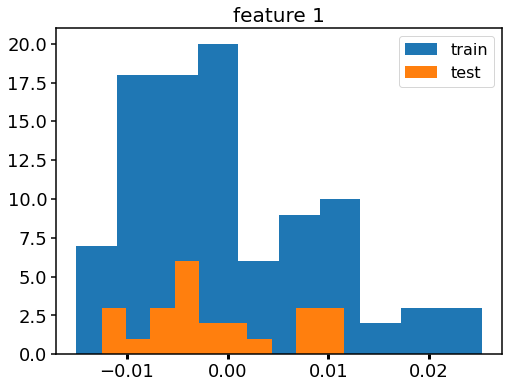

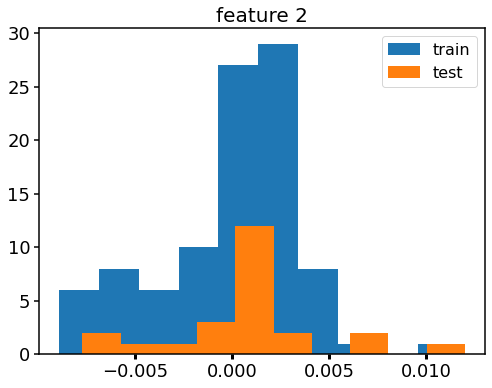

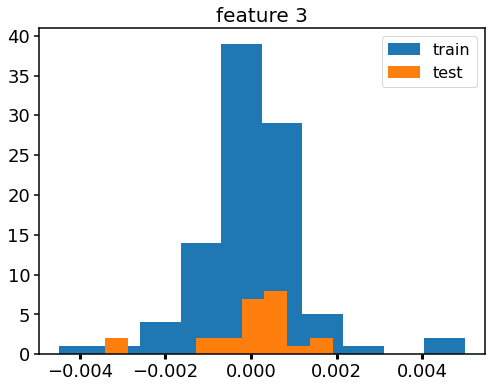

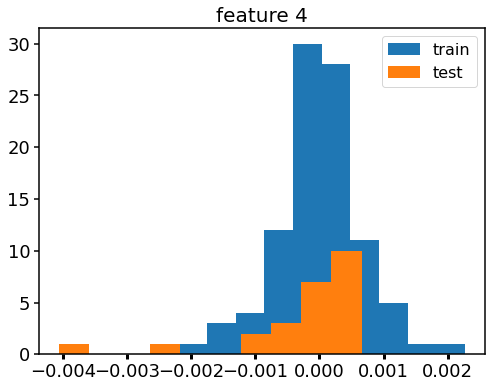

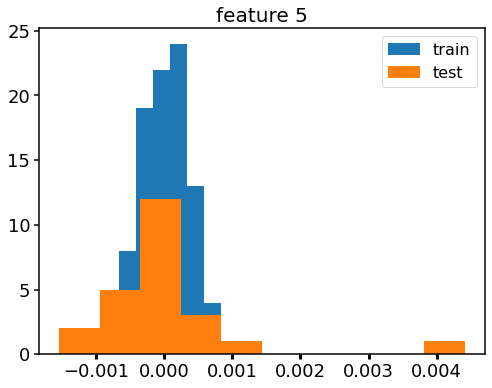

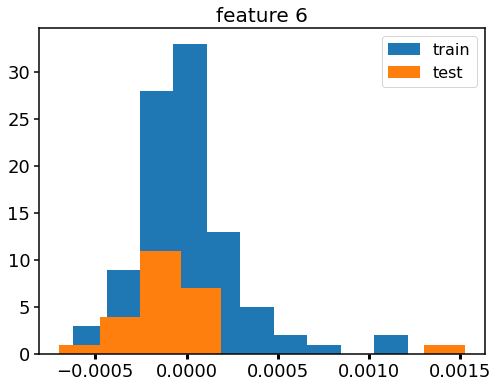

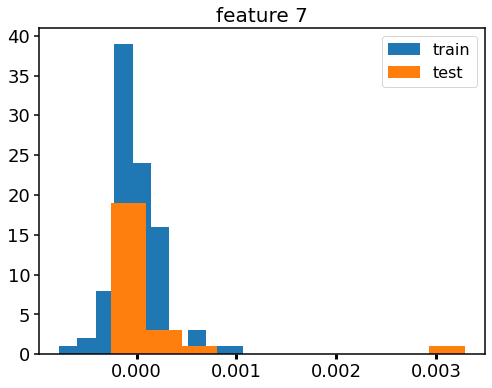

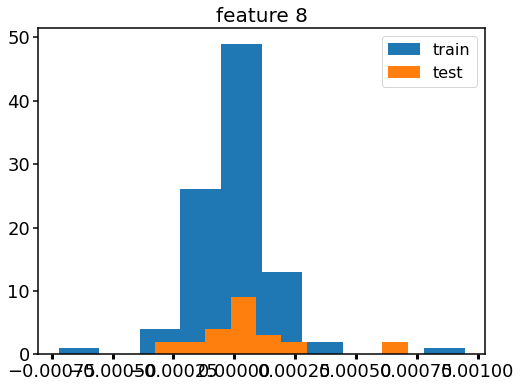

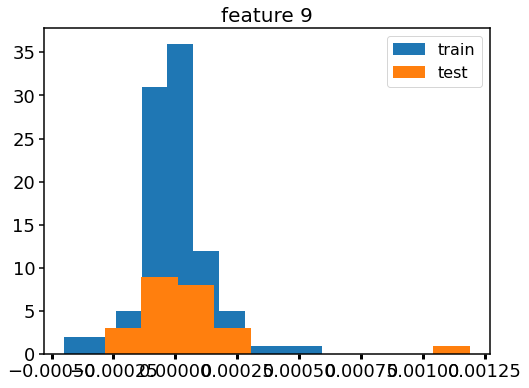

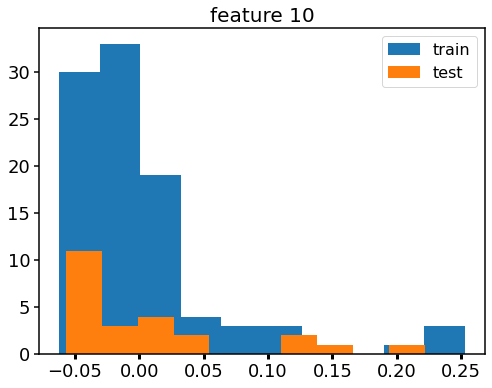

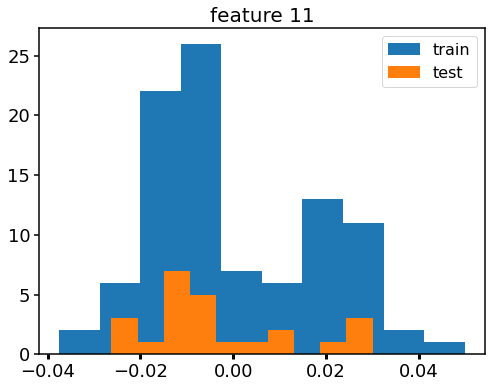

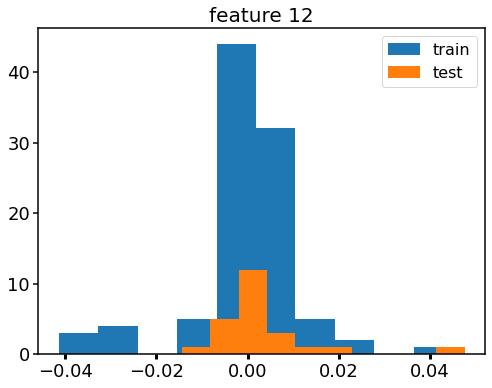

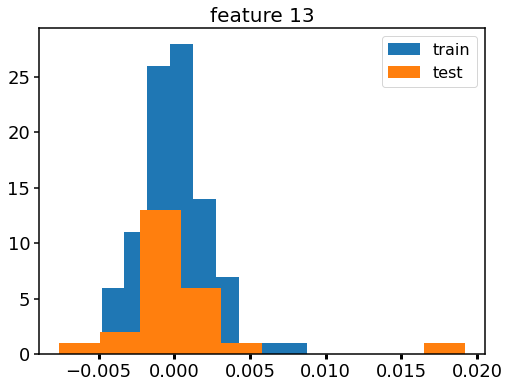

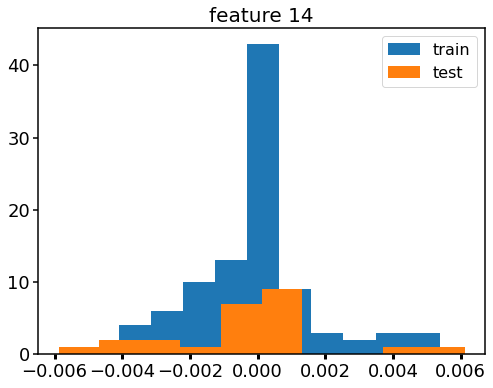

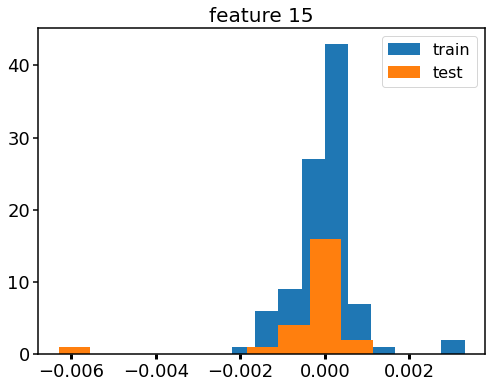

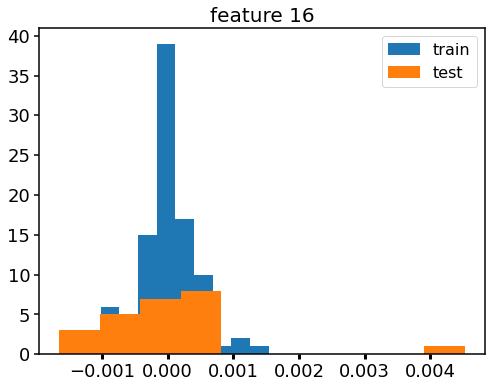

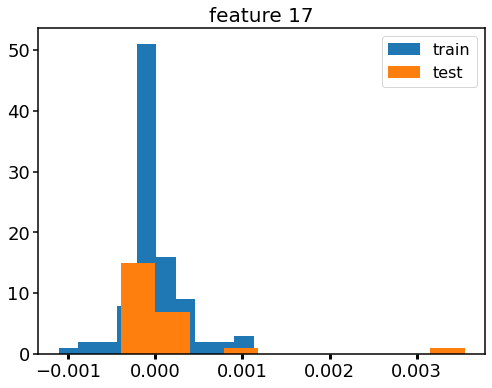

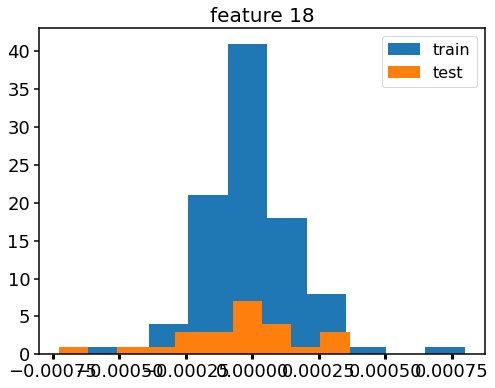

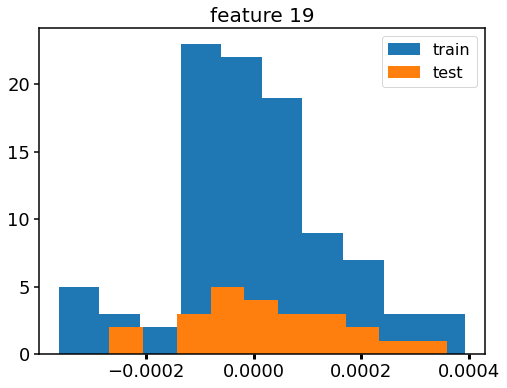

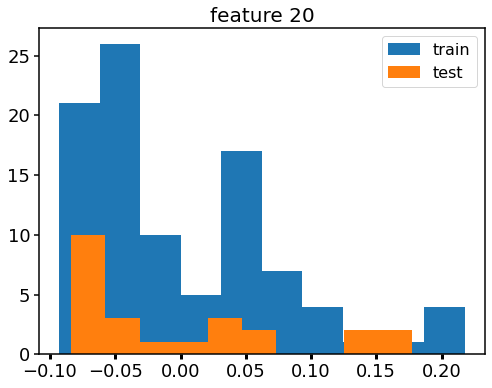

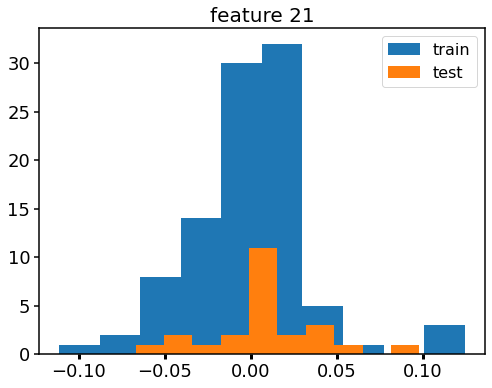

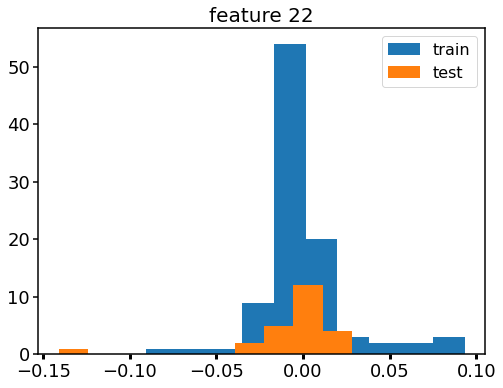

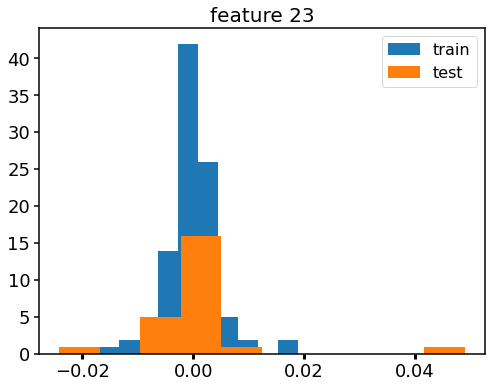

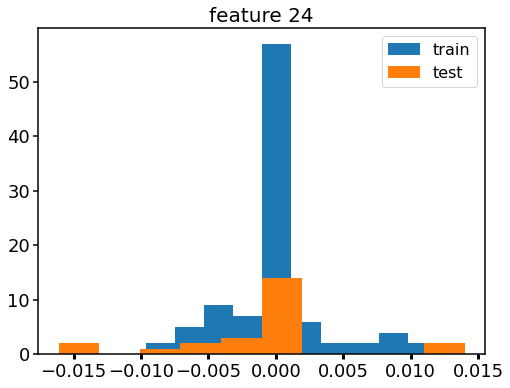

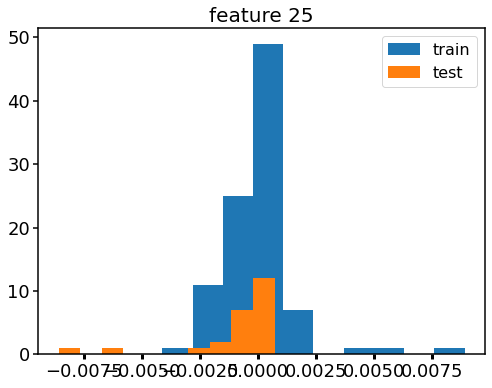

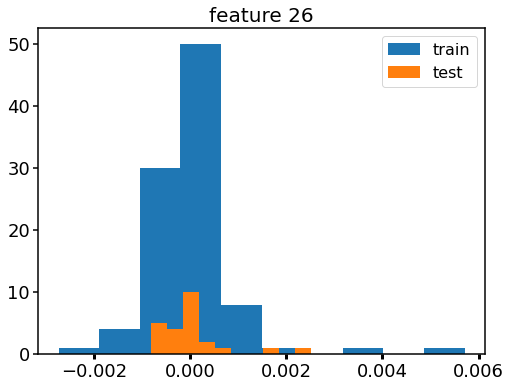

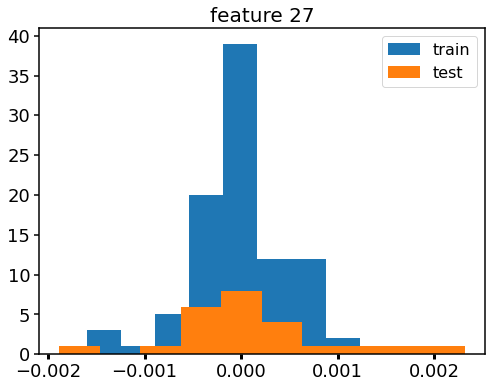

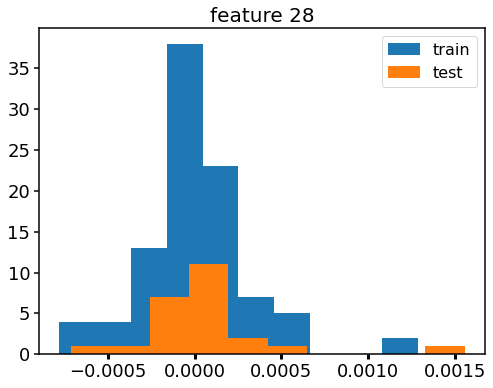

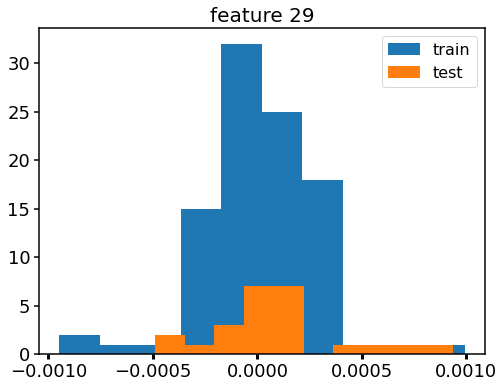

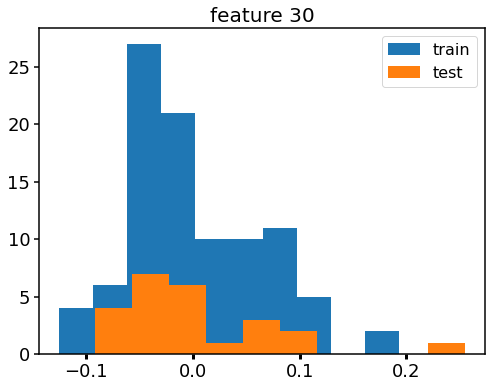

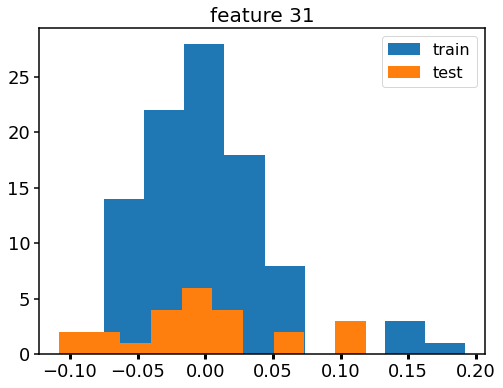

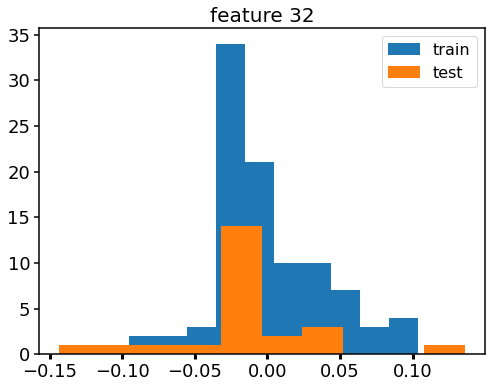

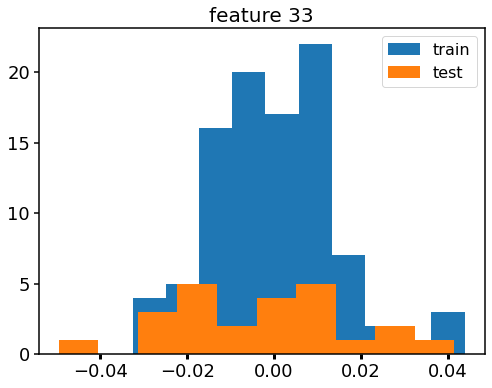

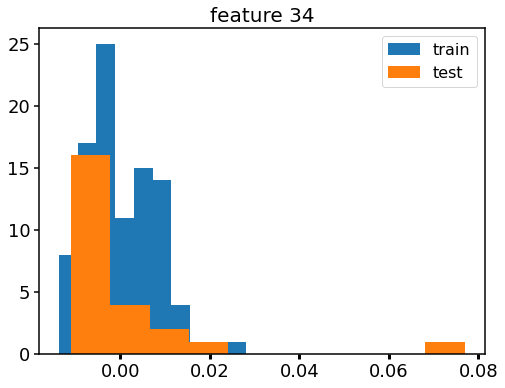

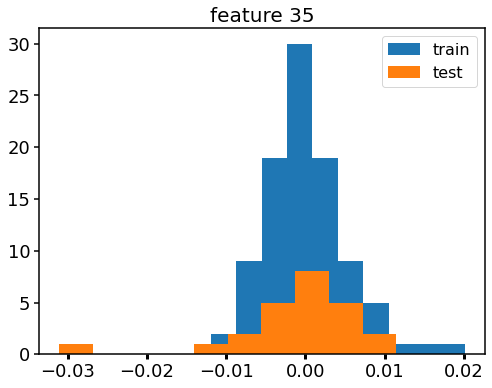

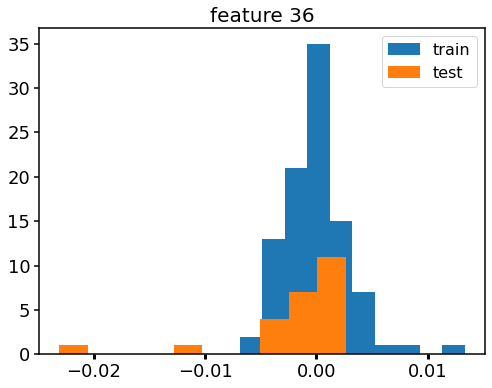

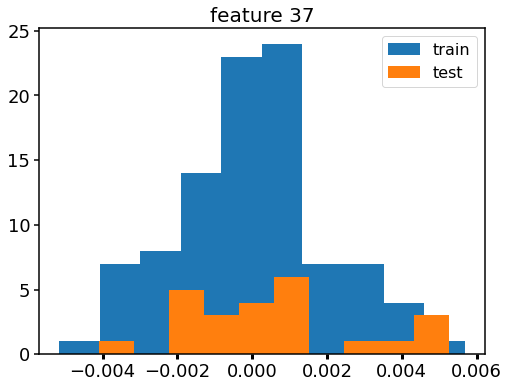

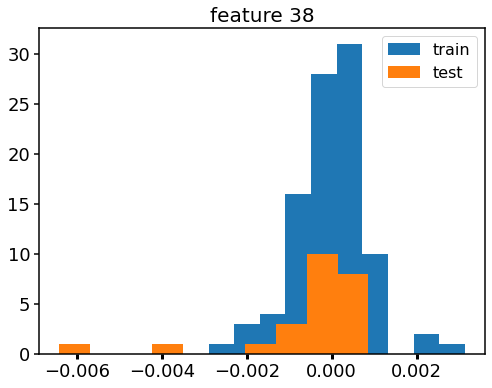

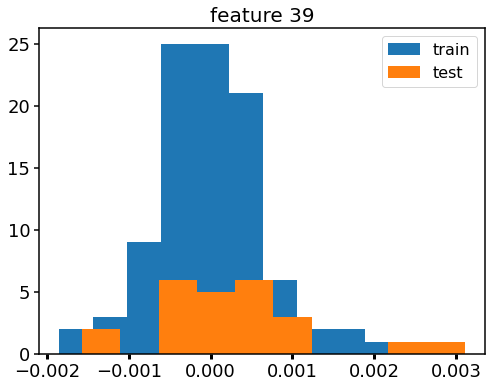

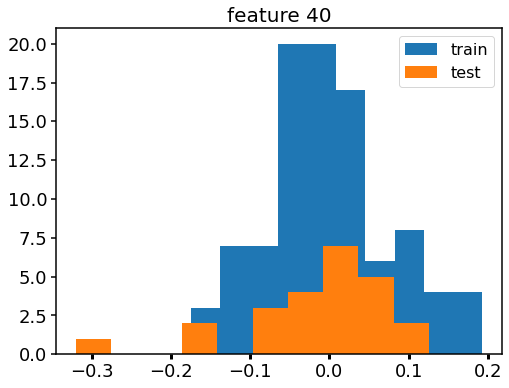

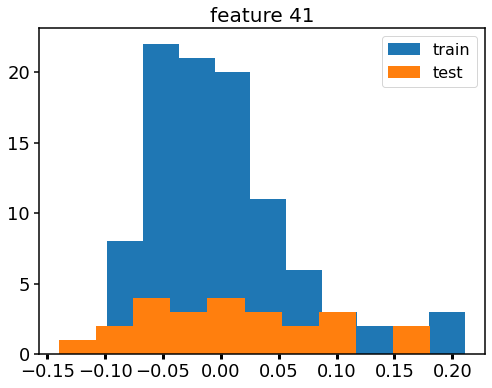

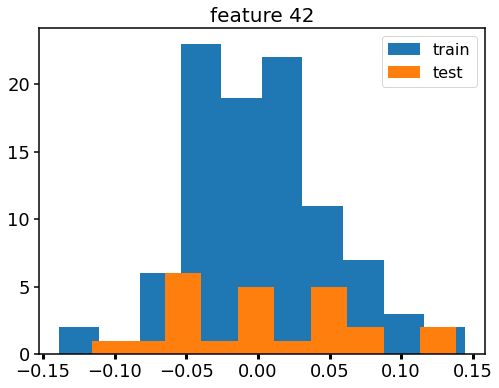

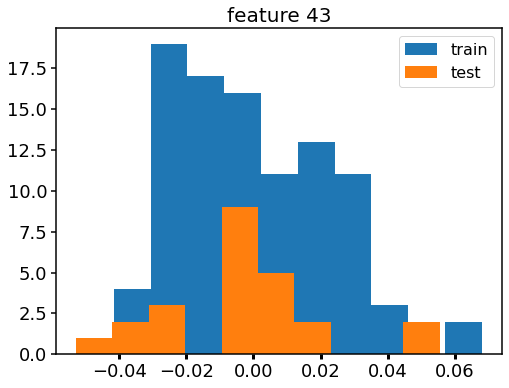

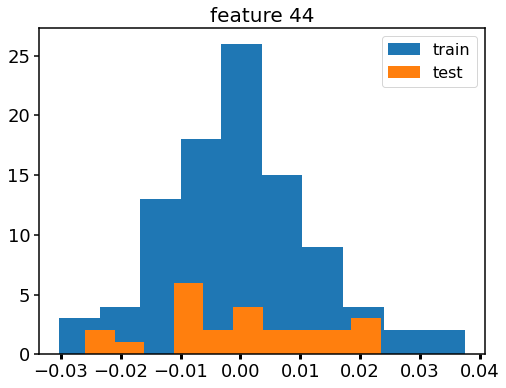

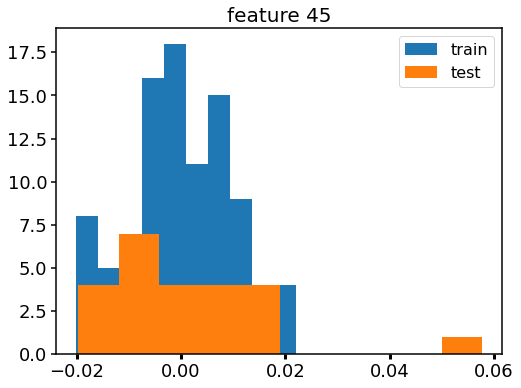

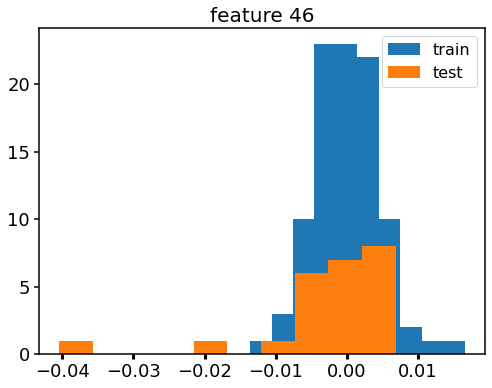

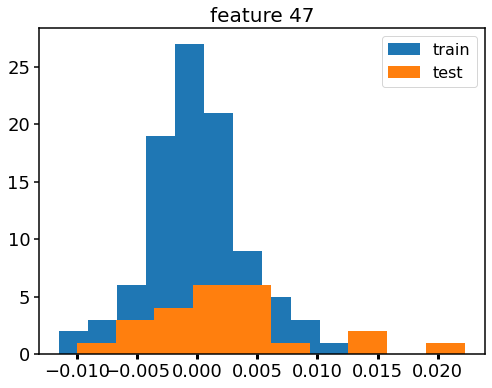

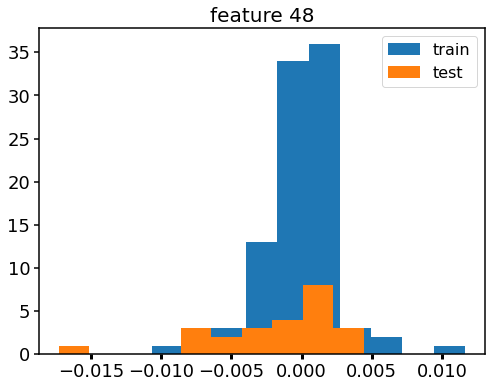

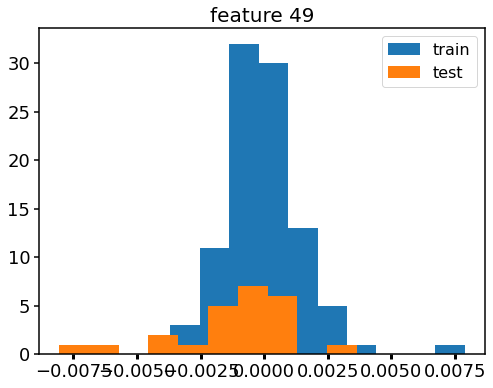

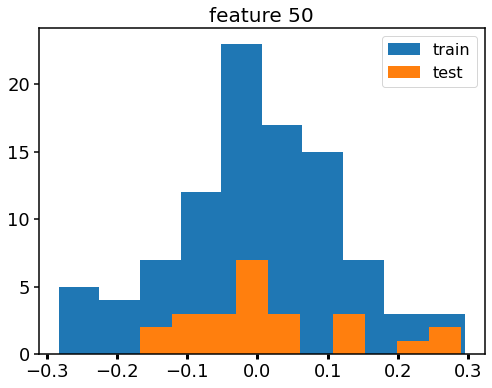

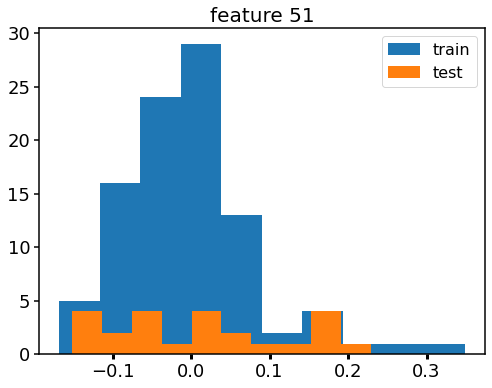

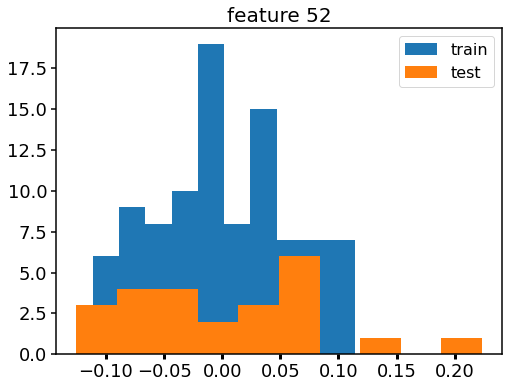

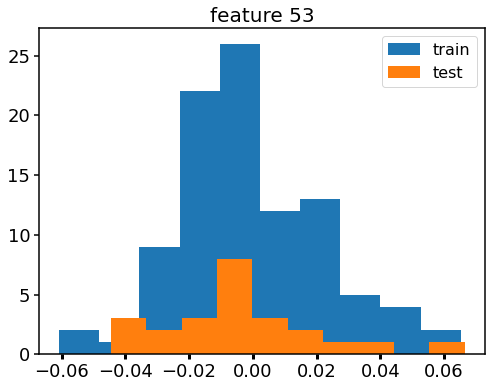

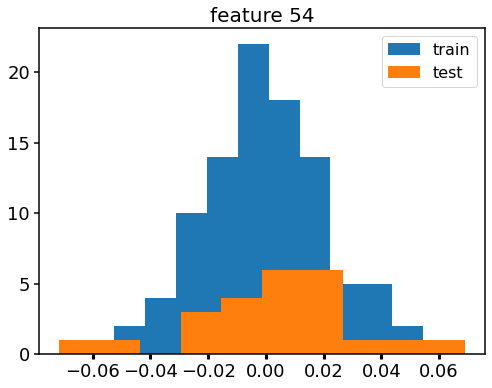

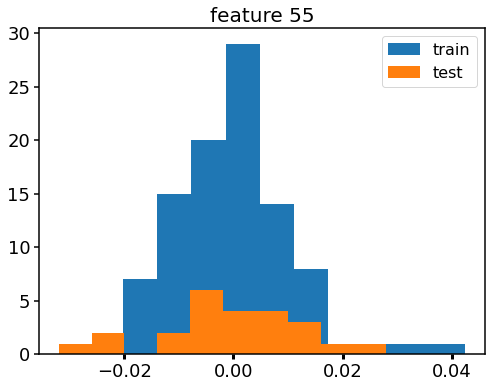

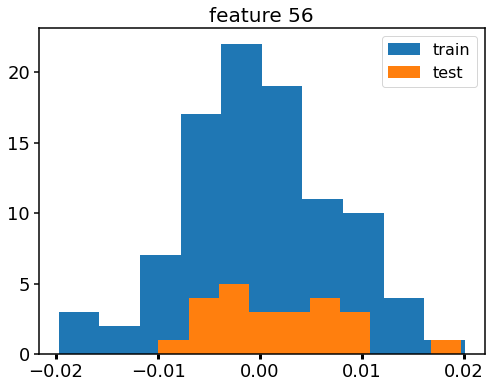

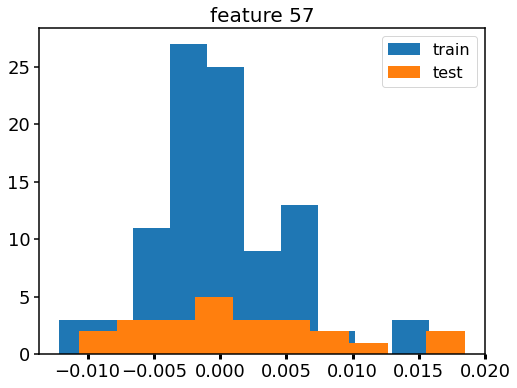

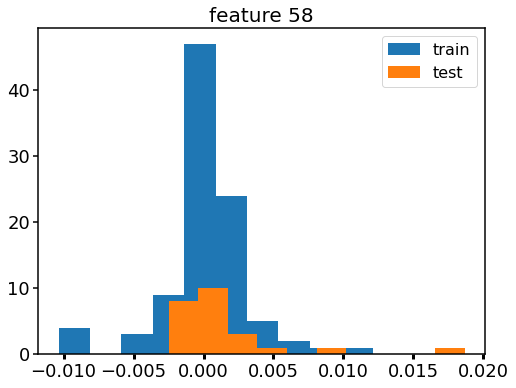

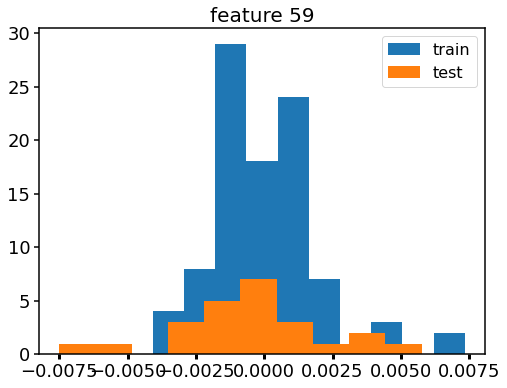

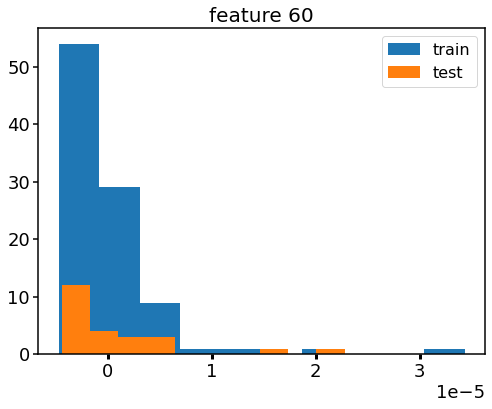

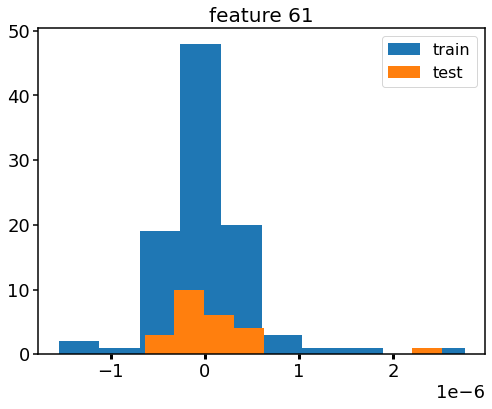

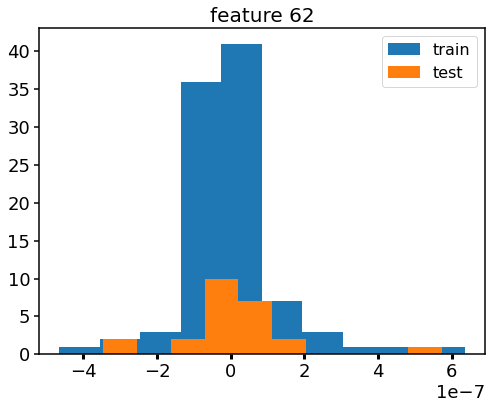

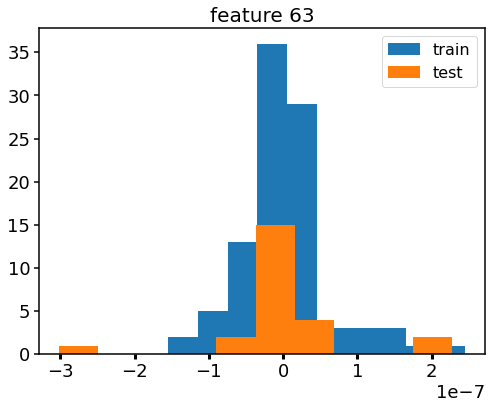

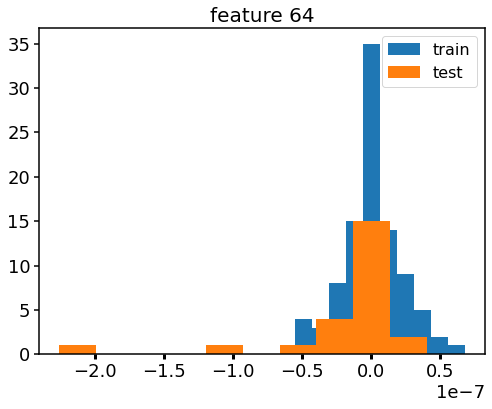

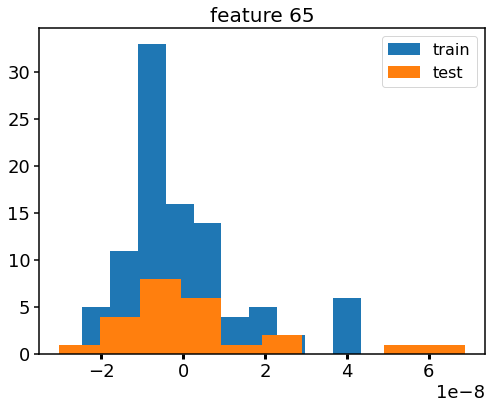

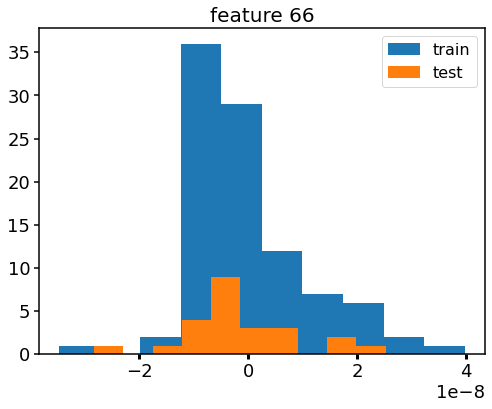

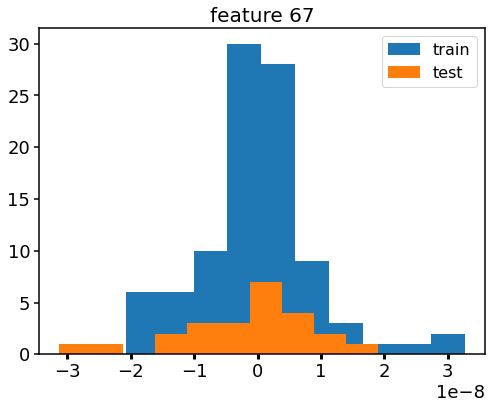

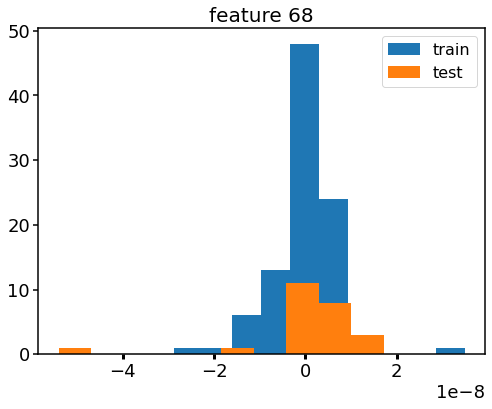

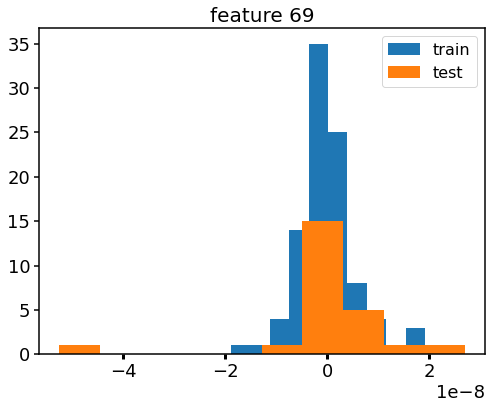

In [45]:
for i in range(features_train.shape[-1]):
    plt.figure()
    plt.title(f'feature {i}')
    feature_train = features_train[:, i]
    feature_test = features_test[:, i]
    plt.hist(feature_train, label='train')
    plt.hist(feature_test, label='test')
    plt.legend()